In this notebook, we will investigate the ability of Wasserstein-GAN (W-GAN) to approximate the 1-Wasserstein distance. We will begin by formulating the problem and selecting ground truth distributions for which the true optimal transport (OT) distances are known.

# Problem Formulation

**Objective:** Given two probability distributions P and Q, we want to compute the 1-Wasserstein distance between them.

In [19]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as dist
from torch.distributions import MultivariateNormal
import ot

import matplotlib.pyplot as plt
import seaborn as sns

# Set the random seed
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Device: cpu


In [20]:
def generate_gaussian_data(n_samples, means, covs):    
    samples = []
    for mean, cov in zip(means, covs):
        distribution = MultivariateNormal(mean, cov)
        samples_per_distribution = distribution.sample((n_samples,))
        samples.append(samples_per_distribution)
    
    return torch.vstack(samples)

In [57]:
# Parameters for two 2D Gaussian distributions
means = [torch.tensor([1.0, -1.0]), torch.tensor([-10.0, 1.0])]
covs = [torch.tensor([[1.0, 0.5], [0.5, 2.0]]),
        torch.tensor([[1.5, -0.5], [-0.5, 1.5]])]

# Generate synthetic data
n_samples = 10_000
data = generate_gaussian_data(n_samples, means, covs)

In [135]:
# Define the two distributions
n_samples = 1000
mean1, cov1 = [0, 0], [[1, 0.5], [0.5, 1]]
mean2, cov2 = [2, 3], [[2, 0], [0, 1]]
dist1 = np.random.multivariate_normal(mean1, cov1, n_samples)
dist2 = np.random.multivariate_normal(mean2, cov2, n_samples)

dist1 = torch.tensor(dist1).float()
dist2 = torch.tensor(dist2).float()

def sinkhorn_divergence(x, y, epsilon, n_iter):
    C = torch.cdist(x, y, p=1)
    K = torch.exp(-C / epsilon)
    a = torch.ones_like(x[:, 0]).float() / x.shape[0]
    b = torch.ones_like(y[:, 0]).float() / y.shape[0]

    for i in range(n_iter):
        a = 1. / (torch.matmul(K, b) + 1e-10)
        b = 1. / (torch.matmul(K.transpose(1, 0), a) + 1e-10)

    M = torch.cdist(a[:, None] * x, b[:, None] * y, p=1)
    sinkhorn_div = (a * (K * M).sum(dim=1)).sum() - epsilon * (a * torch.log(a)).sum() - epsilon * (b * torch.log(b)).sum()

    return sinkhorn_div.item()

sinkhorn_div = sinkhorn_divergence(dist1, dist2, 0.1, 300)
print("Sinkhorn divergence:", sinkhorn_div)

Sinkhorn divergence: 3.546146309278039e+20


In [ ]:
# Compute the Sinkhorn divergence
dist1 = np.random.multivariate_normal(means[0], cov[0], n_samples)
dist2 = np.random.multivariate_normal(means[0], cov[0], n_samples)

M = ot.dist(dist1, dist2)
sinkhorn_div = ot.sinkhorn2(dist1, dist2, M, reg=0.1)
print("Sinkhorn divergence:", sinkhorn_div)

# 2. W-GAN

In [136]:
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim, hidden_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(self.latent_dim, self.hidden_dim)
        # self.fc2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.fc3 = nn.Linear(self.hidden_dim, self.output_dim)


    def forward(self, z):
        x = self.relu(self.fc1(z))
        # x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x

class Critic(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Critic, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.fc1 = nn.Linear(self.input_dim, self.hidden_dim)
        # self.fc2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.fc3 = nn.Linear(self.hidden_dim, 1)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        # x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [137]:
# Hyperparameters
latent_dim = 2
output_dim = 2
input_dim = 2
hidden_dim = 64
batch_size = 256
n_critic = 5
n_epochs = 5_000
lr = 5e-5
clip_value = 0.01

In [138]:
# Initialize the generator and critic
generator = Generator(latent_dim, output_dim, hidden_dim)
critic = Critic(input_dim, hidden_dim)

# Set up the optimizers
optimizer_G = optim.RMSprop(generator.parameters(), lr=lr)
optimizer_C = optim.RMSprop(critic.parameters(), lr=lr)

loss_dict = {'critic': [], 'generator': []}

for epoch in range(n_epochs):
    for _ in range(n_critic):
        critic_losses = []
        # Sample real data
        real_indices = torch.randint(0, len(data), (batch_size,))
        real_samples = data[real_indices]

        # Sample noise and generate fake data
        z = torch.randn(batch_size, latent_dim)
        fake_samples = generator(z)

        # Train the critic
        optimizer_C.zero_grad()
        real_loss = torch.mean(critic(real_samples))
        fake_loss = torch.mean(critic(fake_samples))
        critic_loss = -(real_loss - fake_loss)
        critic_losses.append(critic_loss.item())
        critic_loss.backward()
        optimizer_C.step()

        # Clip critic's weights
        for p in critic.parameters():
            p.data.clamp_(-clip_value, clip_value)
    
    loss_dict['critic'].append(np.mean(critic_losses))

    # Train the generator
    optimizer_G.zero_grad()
    z = torch.randn(batch_size, latent_dim)
    fake_samples = generator(z)
    generator_loss = -torch.mean(critic(fake_samples))
    loss_dict['generator'].append(generator_loss.item())
    generator_loss.backward()
    optimizer_G.step()

    # Print progress
    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{n_epochs}: Critic Loss: {critic_loss.item()}, Generator Loss: {generator_loss.item()}")

Epoch 0/5000: Critic Loss: 0.001387803815305233, Generator Loss: -0.010331734083592892
Epoch 100/5000: Critic Loss: -0.009670548141002655, Generator Loss: -0.009102973155677319
Epoch 200/5000: Critic Loss: -0.009126203134655952, Generator Loss: -0.009260213933885098
Epoch 300/5000: Critic Loss: -0.00889548845589161, Generator Loss: -0.009376863949000835
Epoch 400/5000: Critic Loss: -0.00847499631345272, Generator Loss: -0.009567000903189182


KeyboardInterrupt: 

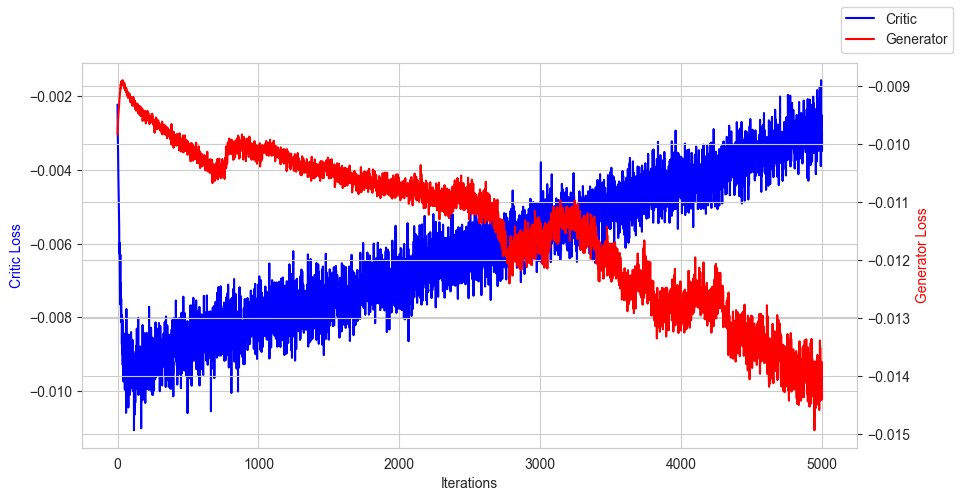

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

# Plot critic loss on left axis
ax1.plot(loss_dict['critic'], label='Critic', color='blue')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Critic Loss', color='blue')

# Plot generator loss on right axis
ax2.plot(loss_dict['generator'], label='Generator', color='red')
ax2.set_ylabel('Generator Loss', color='red')

fig.legend(loc='upper right')
plt.show()

In [115]:
fake_samples = generator(torch.randn(1000, latent_dim)).detach().numpy()

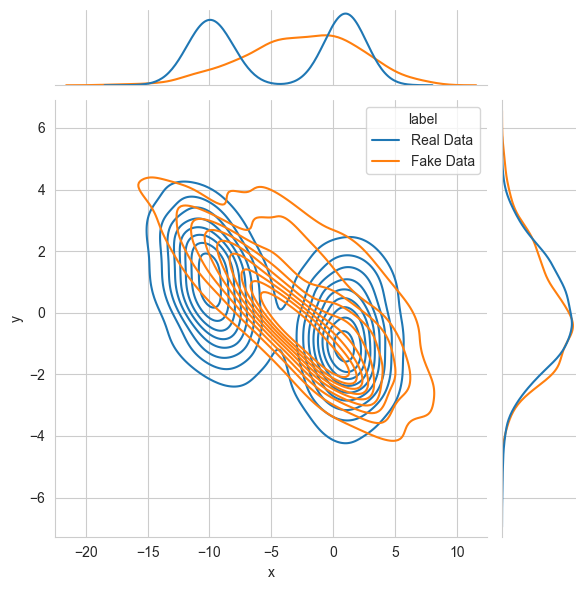

In [116]:
df = pd.DataFrame(data, columns=['x', 'y']).sample(1000)
df['label'] = 'Real Data'
fake_df = pd.DataFrame(fake_samples, columns=['x', 'y'])
fake_df['label'] = 'Fake Data'
df = pd.concat([df, fake_df])

g = sns.jointplot(
    data=df,
    x="x", y="y", hue="label",
    kind="kde",
)

# Sinkhorn divergence